In [1]:

from sentence_to_predicate import WordPredicate
import json
import sentence_grounding_test_parameters as param
import numpy as np
from recognized_object import RecognizedObject

from plots import *
from data_processing import *

import sys
import time
import matplotlib.pyplot as plt
import math
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import keras

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM, Masking, GRU
from keras.layers import Input
from keras.callbacks import ModelCheckpoint
from transformers import BertModel, BertTokenizer
from transformers import pipeline

/home/subbainria/anaconda3/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [3]:
def padding(data_set, max_seq_len = None, special_value = -42):
    if data_set is None:
        return  np.full((1, max_seq_len, nb_unique_words), fill_value=special_value)

    if max_seq_len is None:
        max_seq_len = max([len(s) for s in data_set])

    data_set_pad = np.full((len(data_set), max_seq_len, nb_unique_words), fill_value=special_value)

    for s, x in enumerate(data_set):
        if x is None:
            continue
        seq_len = x.shape[0]
        data_set_pad[s, 0:seq_len, :] = x
    return data_set_pad

In [4]:
def test_with_sentences(sentences, model):
    global max_seq_len
    test = [one_hot_encoding_sentence(s) for s in sentences]
    test_pad = padding(test, max_seq_len)
    res = model.predict(test_pad)
    return res

In [5]:
def test_with_sentences(sentences, model):
    global max_seq_len
    test = []
    for s in sentences:
        #print(s)
        temp = []
        for w in s.split():
            temp.append(nlp(w))
        temp = np.array(temp)
        #print(temp.shape)
        temp = np.reshape(temp,(temp.shape[0], temp.shape[2], temp.shape[3]))
        temp = np.mean(temp, axis=1)
        #print(np.mean(temp, axis=1).shape)
        #print(temp.shape)
        test.append(temp)
    #test = [one_hot_encoding_sentence(s) for s in sentences]
    test_pad = padding(test, max_seq_len)
    res = model.predict(test_pad)
    return res

In [6]:
def test_on_test_set(model, testX, testY, sentences, verbose, threshold_factor):
    test_outputs = model.predict(testX)
    test_res = model.test_on_batch(testX, testY)
    exact = 0
    valid = 0
    for i in range(len(test_outputs)):
        v = output_to_vision(test_outputs[i],nb_concepts,
                             threshold_factor, concepts_delimitations, output_id_to_concept_dict)
        pred = sentence_to_pred(sentences[i], sent_to_role)

        if is_an_exact_representation(pred, v):
            exact +=1

        if is_a_valid_representation(pred, v):
            valid +=1

        if is_a_valid_representation(pred, v) and not(is_an_exact_representation(pred, v)):
            #print(pred, v, test_outputs[i])
            #print(i)
            pass

    nb_sample = testX.shape[0]
    if verbose:
        print("Valid representations : ", valid, "/", nb_sample)
        print("Exact representations : ", exact, "/", nb_sample)
        print("MSE on test : ", test_res)
        print("RMSE on test : ", np.sqrt(test_res))


    return 1-valid/nb_sample, 1-exact/nb_sample, test_res

In [7]:
## to get the evolution of the loss during training
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.exact_errors = []
        self.valid_errors = []

    def on_epoch_end(self, epoch, logs=None):
        global validationX_pad
        global validationY
        self.losses.append(logs.get('loss'))

        v, ex, er = test_on_test_set(self.model, validationX_pad, validationY, validation_sentences, True, 1.3)

        self.val_losses.append(er)
        self.exact_errors.append(ex)
        self.valid_errors.append(v)

    def plot_loss(self):
        plt.figure()
        plt.plot(self.losses, color = "black", label = "loss")
        plt.plot(self.val_losses, color = "red", label = "loss on validation set")
        plt.xlabel("epochs of training")
        plt.title("MSE during training")
        plt.legend()
        plt.show()
        plt.figure()
        plt.title("Performance on validation set during training")
        plt.plot(self.exact_errors, color = "blue", label = "exact error")
        plt.plot(self.valid_errors, color = "green", label = "valid error")
        plt.legend()
        plt.show()

In [8]:
def get_successive_outputs(sentence, model):
    words = sentence.split(" ")
    prefixes = []
    for i in range(len(words)+1):
        prefixes.append(" ".join(words[:i]))
    print(prefixes)
    vect = test_with_sentences(prefixes[1:], model)
    return vect

In [9]:
def get_inner_states(sentences, model, only_last = False, info_obj_nb = False):
    all_states = [[] for i in range(len(model.outputs))]

    clause_nbs =[]

    for k in range(len(sentences)):
        states = get_successive_outputs(sentences[k], model)

        if info_obj_nb:
            words = sentences[k].split(" ")
            clause_id = 0
            clause_nbs.append(clause_id)
            for w in words:
                if w == 'and':
                    clause_id +=1
                clause_nbs.append(clause_id)
                if w == 'and':
                    clause_id +=1
            clause_nbs[-1] = 3 #we also mark the final states

        if not(only_last):
            for j in range(len(states)):
                all_states[j].append(states[j])
        else:
            for j in range(len(states)):
                all_states[j].append(states[j][-1] )

    if not(only_last):
        for i in range(len(all_states)):
            all_states[i] = np.concatenate(all_states[i])
    else:
        for i in range(len(all_states)):
            all_states[i] = np.array(all_states[i])

    if info_obj_nb:
        return all_states, np.array(clause_nbs)
    else:
        return all_states

In [10]:
def plot_hidden_states(sentence, model_for_test, state = 'cell', units_to_plot = 'all', plt_var = False, plt_sum = False):
    activations = get_successive_outputs(sentence, model_for_test)

    plot_hidden_state_activation(sentence,
                                 activations,
                                 state,
                                 units_to_plot,
                                 plot_variation = plt_var,
                                 plot_sum = plt_sum)

In [11]:
################### MAIN #####################

## Parameters

add_begin_end = True #add the word "BEGIN" at the beggining and "END" at the end of all sentences ?
nb_objects = 4 #number of object in the vocabulary used to generate the sentences (the bigger the harder)


special_value = -42 #special value for masking
batch_size = 2
nb_epoch = 35
lstm_units = 20
dropout = 0
test_version = True #if we just create a model to do the task (named "model" in the code)
                    #or in addition, create a model to do extensive test to get access to
                    #cell states of the LSTM (named "model_for_test" in the code)

use_save_version = False #use model saved from a previous run
if use_save_version:
    path = r"saved_LSTM/" #path to the model .hdf5 file(s)
    model_id = '0.9144544314163248' #model id (a random float to identify the file(s) of the model save)

threshold_factor = 1.3 # the factor used to get the threshold in the creation of he discrete representation


minimal_mode = False #if minimal mode is on, the model will only be trained and tested on test set. The only text print will be "nb of objects, valid error on test set, exact error on test set, RMSE on test set, time to train"

verbose_training = True

In [12]:
##dataset initialisation : creation of the sentence according to the grammar

param.create_dataset(nb_objects = nb_objects)

#one hot encoding initialisation
sent_to_role= param.SENTENCE_TO_ROLES


other_words = ['and']
if add_begin_end:
    other_words.append("BEGIN")
    other_words.append("END")

init_one_hot_encoding(list(sent_to_role.keys()) + other_words)
nb_unique_words = len(word2one_hot_id)


In [13]:
#concept dictionnary initialisation (it's the link between the output position and their meaning)
concepts = param.CATEGORIES + param.POSITIONS + param.COLORS

concepts_delimitations = [(0,len(param.CATEGORIES)),
                          (len(param.CATEGORIES),
                          len(param.CATEGORIES) + len(param.POSITIONS)),
                          (len(param.CATEGORIES) + len(param.POSITIONS),
                          len(param.CATEGORIES) + len(param.POSITIONS)+ len(param.COLORS))]

nb_concepts = len(concepts)

output_size = 2*nb_concepts

concept_to_output_id_dict = {}
output_id_to_concept_dict = {}
for i,c in enumerate(concepts):
    concept_to_output_id_dict[c] = i
    output_id_to_concept_dict[i] = c

In [14]:
##generate data

sentences_one_object = list(sent_to_role.keys())
sentences_two_objects = []

for s1 in sentences_one_object:
    for s2 in sentences_one_object:
        sentences_two_objects.append(s1 + " and " + s2)

#we adjust the different dictionnaries to include sentences with BEGIN and END

if add_begin_end:
    for i in range(len(sentences_one_object)):

        sent_to_role["BEGIN "+ sentences_one_object[i]+ " END"] = [0] + sent_to_role[sentences_one_object[i]] + [0]
        sent_to_role["BEGIN "+ sentences_one_object[i]] = [0] + sent_to_role[sentences_one_object[i]]
        sent_to_role[ sentences_one_object[i] + " END"] = sent_to_role[sentences_one_object[i]] + [0]
        sentences_one_object[i] = "BEGIN "+ sentences_one_object[i]+ " END"

    for i in range(len(sentences_two_objects)):
        sentences_two_objects[i] = "BEGIN "+ sentences_two_objects[i]+ " END"

In [15]:
#create the training, test and validation set

np.random.shuffle(sentences_one_object)
np.random.shuffle(sentences_two_objects)

train_one_obj = 300
train_two_objs = 700


test_one_obj = 300
test_two_objs = 700

validation_one_obj = 80
validation_two_objs = 200


In [16]:
train_sentences = (sentences_one_object[:train_one_obj]
              + sentences_two_objects[:train_two_objs])


test_sentences = (sentences_one_object[-test_one_obj:]
              + sentences_two_objects[-test_two_objs:])

validation_sentences = (sentences_one_object[train_one_obj:train_one_obj+validation_one_obj]
              + sentences_two_objects[train_two_objs:train_two_objs+validation_two_objs])


In [ ]:
do_lower_case = True
model = BertModel.from_pretrained("anonymous/BERT-NLP", output_attentions=True)
tokenizer = BertTokenizer.from_pretrained("anonymous/BERT-NLP", do_lower_case=do_lower_case)

nlp = pipeline('feature-extraction',model=model, tokenizer=tokenizer)

In [18]:
trainX = []
for s in train_sentences:
    temp = []
    for w in s.split():
        temp.append(nlp(w))
    temp = np.array(temp)
    temp = np.reshape(temp,(temp.shape[0], temp.shape[2], temp.shape[3]))
    temp = np.mean(temp, axis=1)
    #print(np.mean(temp, axis=1).shape)
    #print(temp.shape)
    trainX.append(temp)

In [19]:
testX = []
for s in test_sentences:
    temp = []
    for w in s.split():
        temp.append(nlp(w))
    temp = np.array(temp)
    temp = np.reshape(temp,(temp.shape[0], temp.shape[2], temp.shape[3]))
    temp = np.mean(temp, axis=1)
    #print(np.mean(temp, axis=1).shape)
    #print(temp.shape)
    testX.append(temp)

In [20]:
validationX = []
for s in validation_sentences:
    temp = []
    for w in s.split():
        temp.append(nlp(w))
    temp = np.array(temp)
    temp = np.reshape(temp,(temp.shape[0], temp.shape[2], temp.shape[3]))
    temp = np.mean(temp, axis=1)
    #print(np.mean(temp, axis=1).shape)
    #print(temp.shape)
    validationX.append(temp)

In [21]:
#trainX = [one_hot_encoding_sentence(s) for s in train_sentences]
trainY = np.array([sentence_to_output_teacher_vector(s, sent_to_role, concept_to_output_id_dict, nb_concepts) for s in train_sentences])

In [22]:
#testX = [one_hot_encoding_sentence(s) for s in test_sentences]
testY = np.array([sentence_to_output_teacher_vector(s, sent_to_role, concept_to_output_id_dict, nb_concepts) for s in test_sentences])

In [23]:
#validationX = [one_hot_encoding_sentence(s) for s in validation_sentences]
validationY = np.array([sentence_to_output_teacher_vector(s, sent_to_role, concept_to_output_id_dict, nb_concepts) for s in validation_sentences])

In [24]:
nb_unique_words = 768

In [25]:
max_seq_len = max([len(s.split(" ")) for s in sentences_two_objects])

trainX_pad = padding(trainX,max_seq_len = max_seq_len)
testX_pad = padding(testX, max_seq_len = max_seq_len)
validationX_pad = padding(validationX, max_seq_len = max_seq_len)

In [26]:
print(trainX_pad.shape, testX_pad.shape, validationX_pad.shape)

(1000, 19, 768) (1000, 19, 768) (280, 19, 768)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19, 768)]         0         
_________________________________________________________________
masking (Masking)            (None, 19, 768)           0         
_________________________________________________________________
lstm (LSTM)                  [(None, 20), (None, 20),  63120     
_________________________________________________________________
dense (Dense)                (None, 22)                462       
Total params: 63,582
Trainable params: 63,582
Non-trainable params: 0
_________________________________________________________________
model for hidden states:  None
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19, 768)]         0         
_________

500/500 - 2s - loss: 0.0408 - val_loss: 0.0523
Valid representations :  275 / 280
Exact representations :  236 / 280
MSE on test :  0.05230232700705528
RMSE on test :  0.22869702010969728

Epoch 00024: saving model to saved_LSTM/best_model0.8232168967921197.hdf5
Epoch 25/35
500/500 - 2s - loss: 0.0397 - val_loss: 0.0509
Valid representations :  278 / 280
Exact representations :  247 / 280
MSE on test :  0.05093028396368027
RMSE on test :  0.22567738912810975

Epoch 00025: saving model to saved_LSTM/best_model0.8232168967921197.hdf5
Epoch 26/35
500/500 - 2s - loss: 0.0388 - val_loss: 0.0498
Valid representations :  278 / 280
Exact representations :  250 / 280
MSE on test :  0.049766335636377335
RMSE on test :  0.2230836964826819

Epoch 00026: saving model to saved_LSTM/best_model0.8232168967921197.hdf5
Epoch 27/35
500/500 - 2s - loss: 0.0381 - val_loss: 0.0488
Valid representations :  279 / 280
Exact representations :  260 / 280
MSE on test :  0.04879853501915932
RMSE on test :  0.22090

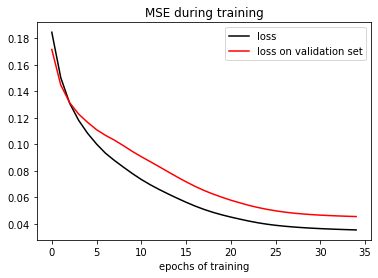

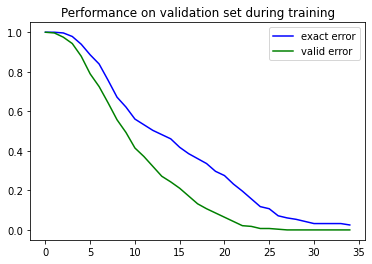

Testing on test set ...
Valid representations :  1000 / 1000
Exact representations :  975 / 1000
MSE on test :  0.04107583686709404
RMSE on test :  0.20267174659309087
Testing on training set ...
Valid representations :  1000 / 1000
Exact representations :  989 / 1000
MSE on test :  0.03596979379653931
RMSE on test :  0.18965704257037044


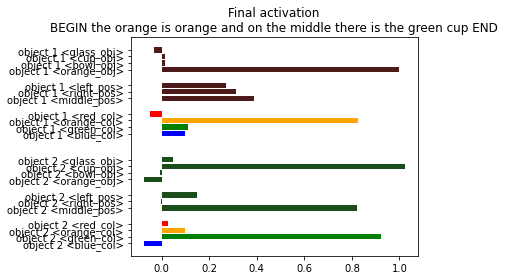

['', 'BEGIN', 'BEGIN the', 'BEGIN the orange', 'BEGIN the orange is', 'BEGIN the orange is orange', 'BEGIN the orange is orange and', 'BEGIN the orange is orange and on', 'BEGIN the orange is orange and on the', 'BEGIN the orange is orange and on the middle', 'BEGIN the orange is orange and on the middle there', 'BEGIN the orange is orange and on the middle there is', 'BEGIN the orange is orange and on the middle there is the', 'BEGIN the orange is orange and on the middle there is the green', 'BEGIN the orange is orange and on the middle there is the green cup', 'BEGIN the orange is orange and on the middle there is the green cup END']
['', 'BEGIN', 'BEGIN the', 'BEGIN the orange', 'BEGIN the orange is', 'BEGIN the orange is orange', 'BEGIN the orange is orange and', 'BEGIN the orange is orange and on', 'BEGIN the orange is orange and on the', 'BEGIN the orange is orange and on the middle', 'BEGIN the orange is orange and on the middle there', 'BEGIN the orange is orange and on the mi

/home/subbainria/Downloads/esn-vs-lstm-on-cross-situationnal-learning/plots.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


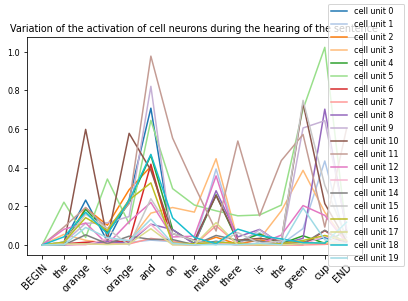

In [27]:
if __name__ == "__main__":
    for i in np.arange(1):
        if use_save_version:
            model = keras.models.load_model(path + "best_model"+rand_id+".hdf5")
            if test_version:
                model_for_test = keras.models.load_model(path + "best_model_for_test"+rand_id+".hdf5")

        else:
            rand_id = str(np.random.random()) #random id used for the file names during the model save

            #build the model
            if test_version:
                inp = Input((max_seq_len, nb_unique_words))
                masked = Masking(mask_value=special_value)(inp)
                lstm_out, state_h, state_c = LSTM(lstm_units, return_state = True, dropout = dropout)(masked)

                output_to_train = Dense(output_size)(lstm_out)

                model = Model(inputs = inp, outputs = output_to_train)
                model_for_test = Model(inputs = inp, outputs = [output_to_train, state_h, state_c])
                model.compile(loss='mean_squared_error', optimizer='adam')
                model_for_test.compile(loss='mean_squared_error', optimizer='adam')

                if verbose_training:
                    print("model for hidden states: ", model_for_test.summary())
            else:
                model = Sequential()
                model.add(Masking(mask_value=special_value, input_shape=(max_seq_len, nb_unique_words)))
                model.add(LSTM(lstm_units, stateful=False))
                model.add(Dense(output_size))
                model.compile(loss='mean_squared_error', optimizer='adam')

            if verbose_training:
                print(model.summary()) # print the architecture of the model

            if not(minimal_mode):
                history = LossHistory() #to get the evolution of the loss during training
                checkpoint = ModelCheckpoint("saved_LSTM/best_model"+rand_id+".hdf5",
                                            monitor='loss', verbose=1,
                                            mode='auto', period=1) #we save the model after each epoch of training

            t1 = time.process_time()

            #training
            if minimal_mode:
                model.fit(trainX_pad, trainY, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
            else:
                model.fit(trainX_pad, trainY, epochs=nb_epoch, batch_size=batch_size, verbose=2, shuffle=False, callbacks=[history, checkpoint], validation_data=(validationX_pad, validationY))


            t2 = time.process_time()

            if verbose_training:
                print("End of training !")
                print("CPU Time to train : ", t2 -t1)
            if not(minimal_mode):
                model_for_test.save("saved_LSTM/best_model_for_test"+rand_id+".hdf5")
                history.plot_loss()


        if verbose_training:
            print("Testing on test set ...")
        v, ex, er = test_on_test_set(model, testX_pad , testY, test_sentences, verbose_training, threshold_factor)
        if minimal_mode:
            print(str(nb_objects) + "," +str(v) + "," + str(ex) + ","+ str(er) + "," + str(t2-t1))

        if not(minimal_mode):
            if verbose_training:
                print("Testing on training set ...")
            v, ex, er = test_on_test_set(model, trainX_pad , trainY, train_sentences, True, threshold_factor)


        #qualitative analysis of the output of the LSTM
        if not(minimal_mode):
            test_sent = ["BEGIN on the middle is a green glass and that is a orange bowl END", #0
            "BEGIN and on the middle is a green glass and that is a orange bowl END",
            "BEGIN a blue bowl is on the right and on the right there is the blue bowl END",
            "BEGIN on the middle there is the orange and the orange on the middle is orange END", #3
            "BEGIN the orange is orange and on the middle there is the green cup END",
            "BEGIN on the left there is a blue glass and this is a orange END",
            "BEGIN the glass on the left is blue and the bowl on the right is green END", #6
            "BEGIN the orange on the right is green and there is a blue cup on the middle END",
            "BEGIN on the right there is a red glass and the cup on the middle is red END",
            "BEGIN a green glass is on the right and on the left is a orange END"] #9

            #plot the final outputs on a test sentence
            outputs = test_with_sentences(test_sent , model)
            ind = 4
            plot_final_activation(outputs[ind],
                                concepts_delimitations,
                                output_id_to_concept_dict,
                                nb_concepts,
                                test_sent[ind])

            #plot and save to png the evolution of the LSTM outputs during the processing of a sentence
            s = test_sent[ind]
            suc_outputs = get_successive_outputs(s, model)
            plot_concept_activation(s,
                                    suc_outputs,
                                    concepts_delimitations,
                                    nb_concepts,
                                    savefig = True,
                                    sub_ttl_fig = s + " LSTM")


            #plot the evolution of cell activity
            activations = get_successive_outputs(s, model_for_test)
            plot_hidden_states(s,
                            model_for_test,
                            units_to_plot = 'all',
                            state = 'cell',
                            plt_var = True,
                            plt_sum = False)

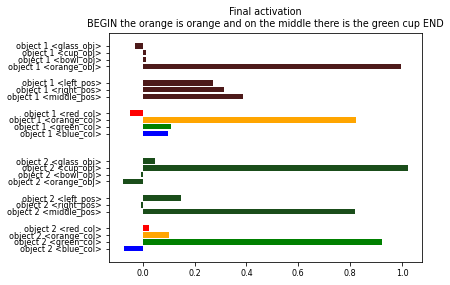

['', 'BEGIN', 'BEGIN the', 'BEGIN the orange', 'BEGIN the orange is', 'BEGIN the orange is orange', 'BEGIN the orange is orange and', 'BEGIN the orange is orange and on', 'BEGIN the orange is orange and on the', 'BEGIN the orange is orange and on the middle', 'BEGIN the orange is orange and on the middle there', 'BEGIN the orange is orange and on the middle there is', 'BEGIN the orange is orange and on the middle there is the', 'BEGIN the orange is orange and on the middle there is the green', 'BEGIN the orange is orange and on the middle there is the green cup', 'BEGIN the orange is orange and on the middle there is the green cup END']
['', 'BEGIN', 'BEGIN the', 'BEGIN the orange', 'BEGIN the orange is', 'BEGIN the orange is orange', 'BEGIN the orange is orange and', 'BEGIN the orange is orange and on', 'BEGIN the orange is orange and on the', 'BEGIN the orange is orange and on the middle', 'BEGIN the orange is orange and on the middle there', 'BEGIN the orange is orange and on the mi

/home/subbainria/Downloads/esn-vs-lstm-on-cross-situationnal-learning/plots.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


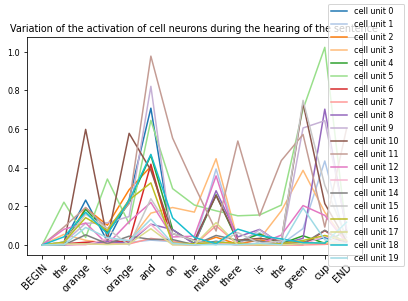

In [29]:
#qualitative analysis of the output of the LSTM
if not(minimal_mode):
    test_sent = ["BEGIN on the middle is a green glass and that is a orange bowl END", #0
        "BEGIN and on the middle is a green glass and that is a orange bowl END",
        "BEGIN a blue bowl is on the right and on the right there is the blue bowl END",
        "BEGIN on the middle there is the orange and the orange on the middle is orange END", #3
        "BEGIN the orange is orange and on the middle there is the green cup END",
        "BEGIN on the left there is a blue glass and this is a orange END",
        "BEGIN the glass on the left is blue and the bowl on the right is green END", #6
        "BEGIN the orange on the right is green and there is a blue cup on the middle END",
        "BEGIN on the right there is a red glass and the cup on the middle is red END",
        "BEGIN a green glass is on the right and on the left is a orange END"] #9

    #plot the final outputs on a test sentence
    outputs = test_with_sentences(test_sent , model)
    ind = 4
    plot_final_activation(outputs[ind],
                            concepts_delimitations,
                            output_id_to_concept_dict,
                            nb_concepts,
                            test_sent[ind])

    #plot and save to png the evolution of the LSTM outputs during the processing of a sentence
    s = test_sent[ind]
    suc_outputs = get_successive_outputs(s, model)
    plot_concept_activation(s, suc_outputs, concepts_delimitations, nb_concepts, savefig = True, sub_ttl_fig = s + " LSTM")


    #plot the evolution of cell activity
    activations = get_successive_outputs(s, model_for_test)
    plot_hidden_states(s,
                        model_for_test,
                        units_to_plot = 'all',
                        state = 'cell',
                        plt_var = True,
                        plt_sum = False)

In [28]:
def plot_concept_activation(sentence, activations, concepts_delim,nb_concepts, output_function = None, savefig=False, sub_ttl_fig='', ylims=(-0.4, 1.4)):
    """
        Plots activation through time of the different concepts while hearing
        the sentence. If output_function is not None, it is applied to the reservoir
        output vector before plotting.
        This is a reuse of a function developped by Alexis Juven.
    """

    outputs = activations.copy()
    activation_threshold = 0.5

    if output_function is not None:

        activation_threshold = output_function(activation_threshold)

        for i in range(outputs.shape[0]):
            outputs[i, :] = output_function(outputs[i, :])


    words = sentence.split(" ")
    max_nb_seen_objects = 2
    nb_object_properties = 3

    fig, axes = plt.subplots(nb_object_properties, max_nb_seen_objects, figsize=(25,20))


    concept_delimitations = [t[0] for t in concepts_delim] + [concepts_delim[-1][1]]

    for i in range(max_nb_seen_objects):

        offset = i * nb_concepts

        axes[0, i].set_title("Object " + str(i+1), fontsize = 26)

        for j in range(nb_object_properties):

            ax = axes[j, i]
            ax.plot(outputs[:, offset + concept_delimitations[j] : offset + concept_delimitations[j+1]], linewidth = 4)
            ax.legend(param.CONCEPT_LISTS[j], loc = 2, fontsize = 26)

            ax.set_yticks([0., 0.5, 1.])
            ax.set_yticklabels([0., 0.5, 1.], fontsize = 24)

            ax.set_ylim([ylims[0], ylims[1]])

            ax.set_xticks(np.arange(len(words)))
            ax.set_xticklabels(words, fontsize = 26)
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize = 28)

            ax.plot(len(words) * [activation_threshold], '--', color = 'grey', linewidth = 3)

    fig.suptitle(sentence, fontsize = 28)
    plt.subplots_adjust(hspace = 0.3)

    if savefig:
        plt.savefig('sentence_'+sub_ttl_fig+".png", bbox_inches='tight')
        plt.close()
    else:
        fig.show()
        #plt.show()